In [2]:
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.io as sio
from scipy.interpolate import interp1d
import math
from scipy import stats
import glob
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC 
import shutil
import os
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 4),
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

# Load data and setup

In [3]:
from analysis_functions import *
from plotting_functions import *

### Define parameters

In [4]:
monkey = 'Stanton'

run_rCTI = True
run_decoders = True
save_figs = True

########### Analysis parameters ###########

# BINNING/SMOOTHING PARAMETERS
bins = np.arange(-500, 3051)
sm_std = 30 # gaussian smoothing stdev
bin_size = 100 # msec for binend data

# rCTI
step_size = 10 # step size for sliding window ROC analysis (in ms)

# DECODING
# Number iterations
n_iter = 200

# Num trials
n_trials_cat = 20 # per dir, so per cat = 60
n_trials_dir = 12 # per dir

# Equal number of neurons per area
count_matched = True

In [5]:
# PATHS
figpath = 'E:\\two_boundary\\figures\\'
datapathsave = 'E:\\two_boundary\\data\\'

brain_areas = ['MT', 'MST', 'LIP', 'SC']
brain_areas = ['MT', 'MST', 'LIP']

# Get number of neurons per area
n_neurons = {}
for area in brain_areas:
    datadir = datapathsave + monkey + '\\' + area + '\\good_neurons\\task_responsive\\'
    os.chdir(datadir)
    n_neurons[area] = len([f for f in glob.glob("*.mat")])
    
# bins for rCTI and decoder plotting
bins_rCTI = np.arange(bins[0], bins[-1], step_size)
bins_decoder = np.arange(bins[0], bins[-1], step_size)

# rCTI direction pairs
DIRS = np.array(DIRS)
BCD_pairs = [[22.5, 157.5], [247.5, 112.5], [202.5, 337.5], [67.5, 292.5]]
BCD_pairs_indx = [[np.where(DIRS == i[0])[0][0], np.where(DIRS == i[1])[0][0]] for i in BCD_pairs]

WCD_pairs = [[337.5, 112.5], [157.5, 292.5], [67.5, 202.5], [247.5, 22.5]]
WCD_pairs_indx = [[np.where(DIRS == i[0])[0][0], np.where(DIRS == i[1])[0][0]] for i in WCD_pairs]


# Quantify single-neuron direction selectivity

# Quantify single-neuron category selectivity (rCTI)

## Setup

In [211]:

'''
BCD_pairs = [[22.5, 157.5], [247.5, 112.5], [202.5, 337.5], [67.5, 292.5], [67.5, 112.5], [202.5, 157.5], [247.5, 292.5], [22.5, 337.5]]
BCD_pairs_indx = [[np.where(DIRS == i[0])[0][0], np.where(DIRS == i[1])[0][0]] for i in BCD_pairs]

WCD_pairs = [[337.5, 112.5], [157.5, 292.5], [67.5, 202.5], [247.5, 22.5], [22.5, 67.5], [202.5, 247.5], [112.5, 157.5], [292.5, 337.5]]
WCD_pairs_indx = [[np.where(DIRS == i[0])[0][0], np.where(DIRS == i[1])[0][0]] for i in WCD_pairs]
'''

'\nBCD_pairs = [[22.5, 157.5], [247.5, 112.5], [202.5, 337.5], [67.5, 292.5], [67.5, 112.5], [202.5, 157.5], [247.5, 292.5], [22.5, 337.5]]\nBCD_pairs_indx = [[np.where(DIRS == i[0])[0][0], np.where(DIRS == i[1])[0][0]] for i in BCD_pairs]\n\nWCD_pairs = [[337.5, 112.5], [157.5, 292.5], [67.5, 202.5], [247.5, 22.5], [22.5, 67.5], [202.5, 247.5], [112.5, 157.5], [292.5, 337.5]]\nWCD_pairs_indx = [[np.where(DIRS == i[0])[0][0], np.where(DIRS == i[1])[0][0]] for i in WCD_pairs]\n'

## rCTI sliding window

### rCTI for all neurons

In [24]:
if run_rCTI:
    
    rCTI_all = {}
    neuron_names_all = {}
    
    for area in brain_areas: 
        currpath = datapathsave + monkey + '\\' + area + '\\good_neurons\\task_responsive\\'

        os.chdir(currpath)
        filelist = [f for f in glob.glob("*.mat")]
        n_files = len(filelist)

        rCTI = [[] for i in range(n_files)]
        names = [[] for i in range(n_files)]

        for i, file in enumerate(filelist):
            data = sio.loadmat(file)['binned_spikes'][0]    
            psth_by_dir = org_data_by_dir(data)

            neuron_name = file[:-4] 
            [WCD_roc_all, WCD_roc] = get_WC_BC_ROC(psth_by_dir, WCD_pairs_indx, step_size)
            [BCD_roc_all, BCD_roc] = get_WC_BC_ROC(psth_by_dir, BCD_pairs_indx, step_size)

            rCTI[i] = BCD_roc-WCD_roc
            names[i] = neuron_name
            
        rCTI_all[area] = np.squeeze(rCTI)

    savepath = figpath + 'rCTI\\' + monkey + '_rCTI.mat'
    sp.io.savemat(savepath,  {'rCTI_all': rCTI_all, 'neuron_names_all': neuron_names_all})

In [ ]:
fake_data = psth_by_dir
tmp_indx = np.where(bins[:-1] > 0)[0]

for i, d in enumerate(psth_by_dir):
    
    tmp = np.zeros_like(d)
    
    if i < 13:
        #tmp[:, tmp_indx] = 100
        
        tmp[:, tmp_indx] = np.random.rand(len(tmp), len(tmp_indx))
        
    fake_data[i] = tmp
   

In [6]:
if monkey != 'both':
    currdatapath = figpath + 'rCTI\\' + monkey + '_rCTI.mat'
    rCTI_all = sio.loadmat(currdatapath)['rCTI_all']
else:     
    currdatapath = figpath + 'rCTI\\' + monkey + '_rCTI.mat'
    rCTI_all = sio.loadmat(currdatapath)['rCTI_all']

rCTI_mean, rCTI_std = {}, {}
for area in brain_areas:
    rCTI_mean[area] = np.mean(rCTI_all[area][0][0], 0)
    rCTI_std[area] = sp.stats.sem(rCTI_all[area][0][0], 0)


#### Plot rCTI

KeyError: 'SC'

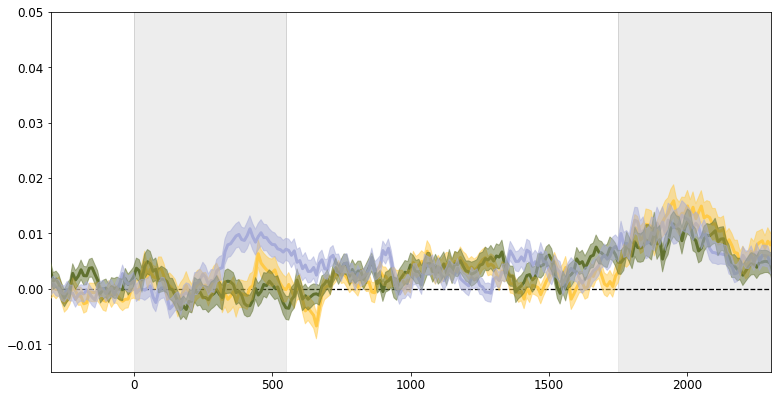

In [6]:
plot_rCTI(rCTI_mean, rCTI_std, n_neurons, brain_areas, bins_rCTI, figpath, monkey, save_fig = False)

### Get proportion cat-tuned and latencies

In [39]:
prop_tuned = {}
latencies_all = {}

bins_rcti = np.arange(-500, 3550-500, 10)
baseline_indx = np.where(bins_rcti < 0)[0]
n_consec = 4

for area in brain_areas:
    
    currpath = datapathsave + monkey + '\\' + area + '\\good_neurons\\task_responsive\\'
    os.chdir(currpath)
    filelist = np.array([f for f in glob.glob("*.mat")])

    make_dirs('category_tuned')

    longest_run = np.zeros(n_neurons[area])
    latencies = np.zeros(n_neurons[area])

    for i_neuron in range(n_neurons[area]):                 
        mean_baseline = np.mean(rCTI_all[area][0][0][i_neuron][baseline_indx])
        std_baseline = np.std(rCTI_all[area][0][0][i_neuron][baseline_indx])

        thresh_above = mean_baseline + std_baseline*3 - mean_baseline
        thresh_below = mean_baseline - std_baseline*3 - mean_baseline

        above_thresh_indx = [1 if i > thresh_above else 0 for i in rCTI_all[area][0][0][i_neuron, baseline_indx[-1]:TEST1+500]]
        [run, lat] = max_consecutive_vals(rCTI_all[area][0][0][i_neuron, baseline_indx[-1]:TEST1+500], thresh_above, n_consec)

        longest_run[i_neuron] = run

        if lat:
            latencies[i_neuron] = bins_rcti[lat + baseline_indx[-1]] 
        else:
            latencies[i_neuron] = np.nan

    prop_tuned[area] = (len(np.where(longest_run >= n_consec)[0])/n_neurons[area])

    latencies_cleaned = [i for i in latencies if not np.isnan(i)]
    latencies_all[area] = latencies_cleaned
    
    sig_indx = np.where(longest_run >= n_consec)[0]

    for file in filelist[np.where(longest_run >= n_consec)[0]]:
        destination_mat = 'category_tuned\\' + file
        figfile = currpath + file
        shutil.copy(file, destination_mat)    
    

In [42]:
data = rCTI_all[area][0][0][i_neuron][baseline_indx[-1]:]
value = 0.001
thresh = 3
indx_thresh = []

counter = 0
longest_run = 0
for i, val in enumerate(data[:-1]):
    if val >= value and data[i+1] >= value:
        if counter == 0:
            counter = 2
        else:
            counter += 1

        if counter >= thresh and not indx_thresh:
            indx_thresh = i

        if counter > longest_run:
            longest_run = counter
    else:
        counter = 0

In [8]:
longest_run

array([  2.,  50.,   6.,   6.,   4.,  12.,   2.,   0.,   0.,   0.,   2.,
        10.,   4.,   3.,   4.,   3.,  10.,   5.,   4.,   6.,   0.,   9.,
        19.,   4.,   3.,   3.,   0.,  11.,   0.,   3.,   5.,   0.,   2.,
         8.,   0.,  24.,  52.,   0.,   0.,   4.,  24.,   4.,   0.,   0.,
         0.,   5., 157.,   3.,  26.,   0.,   0.,   0.,   0.,   0.,   0.,
         5.,   7.,   0.,   4.,   4.,   0.,  89., 111.,   3., 181.,   3.,
         0.,   0.,   2.,   0.])

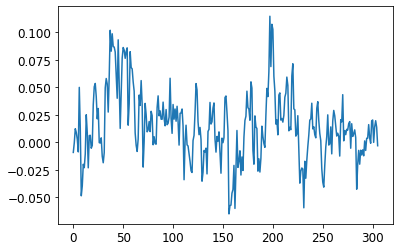

In [29]:
plt.plot(rCTI_all[area][0][0][i_neuron][baseline_indx[-1]:])

In [14]:
rCTI_all[area][0][0][i_neuron][baseline_indx[-1]:]

array([ 1.08205598e-02,  9.44749827e-03,  5.42902109e-03,  1.99277671e-02,
        5.89976211e-03, -6.81870545e-04, -6.81870545e-04, -3.93431894e-02,
       -4.06911114e-02, -4.63189969e-02, -2.66543044e-02, -2.58346620e-02,
        2.43153702e-04, -4.22113201e-03, -2.93725671e-02, -3.92729872e-02,
       -2.15179294e-02, -5.40681829e-03, -1.00652650e-02,  2.40351157e-03,
        1.92689173e-02,  1.92689173e-02,  2.03849887e-02,  4.27387759e-03,
        3.97492988e-03, -1.31225758e-02, -1.25273377e-02, -2.63387216e-02,
       -4.24420379e-02, -3.87397810e-02, -4.01026282e-02, -2.17621644e-02,
       -1.39843867e-02, -1.50954978e-02,  2.14584988e-02,  2.82515370e-02,
        2.82515370e-02,  3.05859865e-02,  2.75068251e-02,  1.24026584e-02,
       -1.83162519e-03, -2.30994152e-03, -1.06859410e-03, -3.23937961e-02,
       -3.17161813e-02, -2.57635299e-02, -2.08897406e-02, -1.72176192e-02,
       -1.53043539e-02,  1.13716740e-02, -5.86507191e-03, -5.17255113e-03,
        1.22288626e-02,  

In [13]:
mean_baseline

0.0073228691564633805

In [12]:
std_baseline*3 

0.10581441646823334

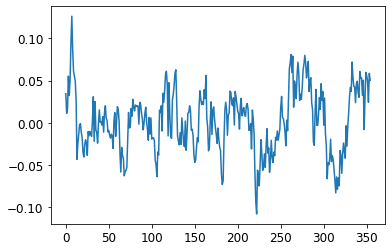

In [18]:
plt.plot(rCTI_all[area][0][0][i_neuron])

In [16]:
latencies_all

{'MT': [], 'MST': [], 'LIP': [], 'SC': []}

In [103]:
mean_baseline = np.mean(rCTI_all[area][0][0][118][baseline_indx])
std_baseline = np.std(rCTI_all[area][0][0][118][baseline_indx])

In [105]:
std_baseline*5

0.05437533074176418

In [233]:
np.mean(rCTI_all[area][0][0][20][baseline_indx])

0.002227938979217474

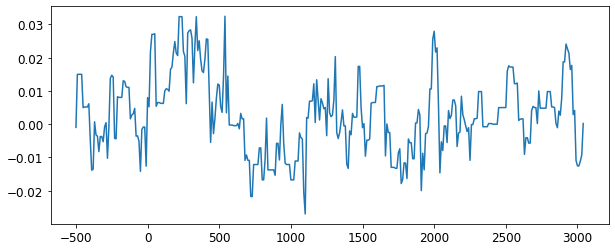

In [232]:
plt.plot(bins_rcti, rCTI_all['MT'][0][0][20])

In [8]:
latencies

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan])

In [50]:
np.mean(rCTI_all[area][0][0][7][baseline_indx])

-0.0012621928528856572

In [227]:
filelist[np.where(latencies < 500)]

array(['20200710_2_SPK03b.mat', '20200710_2_SPK06b.mat',
       '20200710_2_SPK15a.mat', '20200710_2_SPK16b.mat',
       '20200710_2_SPK20a.mat', '20200710_2_SPK20b.mat',
       '20200710_2_SPK22a.mat', '20200721_1_SPK01b.mat',
       '20200721_1_SPK04b.mat', '20200721_1_SPK09a.mat',
       '20200721_1_SPK11a.mat', '20200721_1_SPK15a.mat',
       '20200721_1_SPK21a.mat', '20200728_2_SPK22a.mat',
       '20200808_1_SPK05a.mat', '20200808_1_SPK07c.mat',
       '20200808_1_SPK13a.mat', '20200814_1_SPK01a.mat',
       '20200814_1_SPK02a.mat', '20200907_2_SPK12a.mat',
       '20200907_2_SPK15b.mat', '20200907_2_SPK16a.mat',
       '20200917_2_SPK06b.mat', '20200917_2_SPK14c.mat',
       '20200917_2_SPK22a.mat', '20200918_1_SPK02a.mat',
       '20200918_1_SPK03a.mat', '20200925_1_SPK02a.mat',
       '20200925_1_SPK08a.mat', '20200925_1_SPK09a.mat',
       '20200925_1_SPK20a.mat', '20200925_2_SPK20a.mat',
       '20200925_2_SPK22b.mat'], dtype='<U21')

In [226]:
np.where(latencies < 500)

(array([  3,   6,  18,  20,  26,  27,  29,  32,  36,  44,  48,  52,  57,
         66,  69,  72,  74,  81,  82, 104, 109, 110, 120, 135, 142, 144,
        145, 153, 158, 159, 163, 178, 180], dtype=int64),)

# Single-neuron decoders

## Category

In [6]:
cat_decoder_all = {}
n_iter = 10
n_shuffles = 500

for area in brain_areas: 
    currpath = datapathsave + monkey + '\\' + area + '\\good_neurons\\task_responsive\\'
    
    cat_decoder_all[area] = {'real_data': [], 'shuffled': []}

    os.chdir(currpath)
    filelist = [f for f in glob.glob("*.mat")]
    n_files = len(filelist)

    decoder_real = [[] for i in range(n_files)]
    decoder_shuffled = [[] for i in range(n_files)]

    for i_file, file in enumerate(filelist):
        data = sio.loadmat(file)['binned_spikes'][0]    
        psth_by_dir = org_data_by_dir(data)
        
        perf_all = category_decoder(psth_by_dir, n_iter, bins, 1, 1, n_trials_cat, equal_n_per_dir = True)
        decoder_real[i_file] = np.mean(perf_all, 0)
        
        n_trials_per_dir_cum = np.cumsum([len(i) for i in psth_by_dir])
        all_trials = np.vstack([i for i in psth_by_dir])

        all_shuffles = np.zeros([n_shuffles, np.int(np.floor(len(bins)/10))])

        for i_shuffle in range(n_shuffles):
            data = all_trials
            np.random.shuffle(data)

            shuffled_data = [[] for i in range(N_DIRS)]

            for i_dir in range(N_DIRS):   
                if i_dir == 0:
                    shuffled_data[i_dir] = data[:n_trials_per_dir_cum[i_dir]]
                else:
                    shuffled_data[i_dir] = data[n_trials_per_dir_cum[i_dir-1]:n_trials_per_dir_cum[i_dir]]

            all_shuffles[i_shuffle] = category_decoder(shuffled_data, 1, bins, 1, 1, n_trials_cat, equal_n_per_dir = True)[0]
        decoder_shuffled[i_file] = all_shuffles
        
    cat_decoder_all[area]['real_data'] = decoder_real
    cat_decoder_all[area]['shuffled'] = decoder_shuffled
    
savepath = figpath + 'single_neuron_decoding\\' + monkey + '_cat_decoding.mat'
sp.io.savemat(savepath,  {'cat_decoder_all': cat_decoder_all})

In [7]:
def max_consecutive_vals_below(data, value, thresh):
    indx_thresh = []

    counter = 0
    longest_run = 0
    for i, val in enumerate(data[:-1]):
        if val <= value and data[i+1] <= value:
            if counter == 0:
                counter = 2
            else:
                counter += 1

            if counter <= thresh and not indx_thresh:
                indx_thresh = i

            if counter > longest_run:
                longest_run = counter
        else:
            counter = 0

    return longest_run, indx_thresh

In [16]:
prop_tuned = {}
latencies_all = {}

bins_rcti = np.arange(-500, 3550-500, 10)
indx = np.where(bins_rcti >= 0)[0]
n_consec = 4

for area in brain_areas[0:1]:
    
    currpath = datapathsave + monkey + '\\' + area + '\\good_neurons\\task_responsive\\'
    os.chdir(currpath)
    filelist = np.array([f for f in glob.glob("*.mat")])

    make_dirs('category_tuned')

    longest_run = np.zeros(n_neurons[area])
    latencies = np.zeros(n_neurons[area])

    for i_neuron in range(n_neurons[area]):                 

        p_vals = ([sum(cat_decoder_all[area]['shuffled'][i_neuron][:, i] >= cat_decoder_all[area]['real_data'][i_neuron][i])/n_shuffles for i in indx])
        
        [run, lat] = max_consecutive_vals_below(p_vals, 0.05, n_consec)

        longest_run[i_neuron] = run

        if lat:
            latencies[i_neuron] = bins_rcti[lat] 
        else:
            latencies[i_neuron] = np.nan

    prop_tuned[area] = (len(np.where(longest_run >= n_consec)[0])/n_neurons[area])

    latencies_cleaned = [i for i in latencies if not np.isnan(i)]
    latencies_all[area] = latencies_cleaned + abs(bins_rcti[0])
    
    sig_indx = np.where(longest_run >= n_consec)[0]

    for file in filelist[np.where(longest_run >= n_consec)[0]]:
        destination_mat = 'category_tuned\\' + file
        figfile = currpath + file
        #shutil.copy(file, destination_mat)    
    

In [17]:
latencies

array([  nan,   nan, 2170.,  190.,  100.,    0., 1450.,   nan, -330.,
       1270., -450., -350.,   20., 1890.,  650.,  330., -290.,   nan,
         nan,  690., 1910.,  -50.,   nan,  360.,  320.,  950., -370.,
       1500.,  830.,  500.,   nan,   50.,  480.,  720., 1810.,  200.,
       1320., 1150.,  360., -330.,   nan, -340.,   nan,  490., -140.,
        160., -490.,   nan, 1340.,   nan, 2410.,   90., -240., -330.,
       1350., -320.,   80., 1430., 2460., -320.,   40.,  770.,  800.,
        440., -360.,  100., -490., 1690., 1620., 1830.,  -70., -190.,
       1510.,  420.,  330.,   nan,   nan, 1550.,  950.,   nan,   nan,
       1450., -230., 1470.,  450.,  840.,  240., 1600.,  150.,  600.,
        160., 1580., -200.,   nan,   nan,  -10.,   nan,  490., 2290.,
         20., -440., -100., 1680.,  890.,  530., 1350.,  490., 1360.,
       -120.,   nan, -440., -250.,  770., 1680.,   30.,  970.,  390.,
       1510., 2090., 1380., -400.,   nan, -350.,   nan, -340., -330.,
        140.,  240.,

In [15]:
prop_tuned

{'MT': 0.3442622950819672,
 'MST': 0.27906976744186046,
 'LIP': 0.3181818181818182}

#### Plot proportion category-tuned

In [200]:
#os.chdir('category_tuned')
filelist = np.array([f for f in glob.glob("*.mat")])
filelist[9]

'20180905_1_sig012a.mat'

In [40]:
prop_tuned

{'MT': 0.453551912568306,
 'MST': 0.4476744186046512,
 'LIP': 0.4494949494949495,
 'SC': 0.4714285714285714}

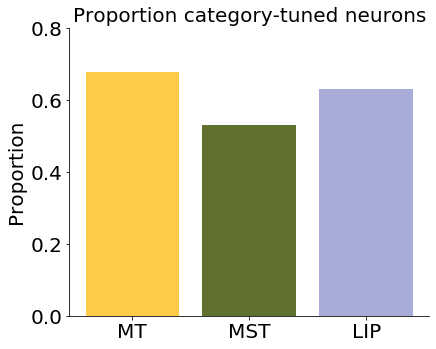

In [13]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes([1,1,1,1])

ax.bar(brain_areas[0:3], [prop_tuned['MT'], prop_tuned['MST'], prop_tuned['LIP']], color = [plot_colors['MT'], plot_colors['MST'], plot_colors['LIP']])
ax.set_ylabel('Proportion', fontsize = 20)

ax.set_title('Proportion category-tuned neurons', fontsize = 20)
plt.ylim(0, 0.8)

plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tick_params(labelsize=20)

plt.show()

for i in save_filetype:
    savepath = figpath + 'rCTI\\' + monkey + '_rCTI_prop_tuned.' + i
    #fig.savefig(savepath, bbox_inches='tight')

#### Calculate and plot ECDF of latency

In [10]:
x_vals = [[] for i in range(4)]
y_vals = [[] for i in range(4)]

latencies_array = [[] for i in range(4)]

for i, area in enumerate(brain_areas):
    [x, y] = ecdf(latencies_all[area])
    x_vals[i] = x
    y_vals[i] = y
    
    latencies_array[i] = np.array(latencies_all[area])

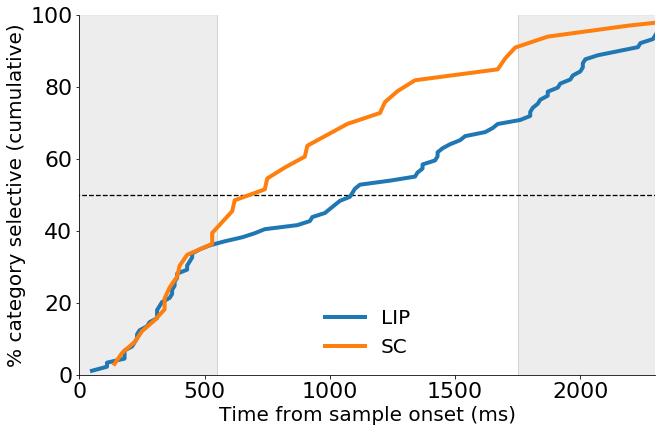

In [43]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes([1,1,1,1])

ax.plot([0, 0], [0, 100], 'lightgrey', lw = 1)
for i in range(4):
    ax.plot([TRIAL_EPOCHS[i], TRIAL_EPOCHS[i]], [0, 100], 'lightgrey', lw = 1)

ax.plot([-400, 3000], [50, 50], '--k', lw = 1.3)
plt.ylim([0, 100])
plt.xlim([0, TEST1])
#plt.xlim([2800, test2])

ax.axvspan(0, SAMPLE_STIM, alpha = 0.4, color = 'lightgrey', zorder=1)
ax.axvspan(DELAY1, TEST1, alpha = 0.4, color = 'lightgrey', zorder=2)

plt.plot(x_vals[2], y_vals[2]*100, lw = 4, label = 'LIP')
plt.plot(x_vals[3], y_vals[3]*100, lw = 4, label = 'SC')


ax.set_xlabel('Time from sample onset (ms)', fontsize = 20)
ax.set_ylabel('% category selective (cumulative)', fontsize = 20)
ax.legend(frameon = False, fontsize = 20)

plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

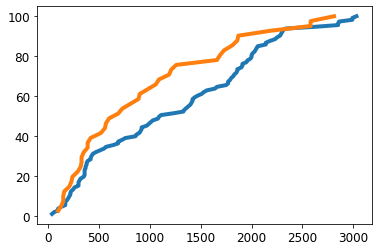

In [25]:



# Hide the right and top spines
ax[1, 0].spines['right'].set_visible(False)
ax[1, 0].spines['top'].set_visible(False)

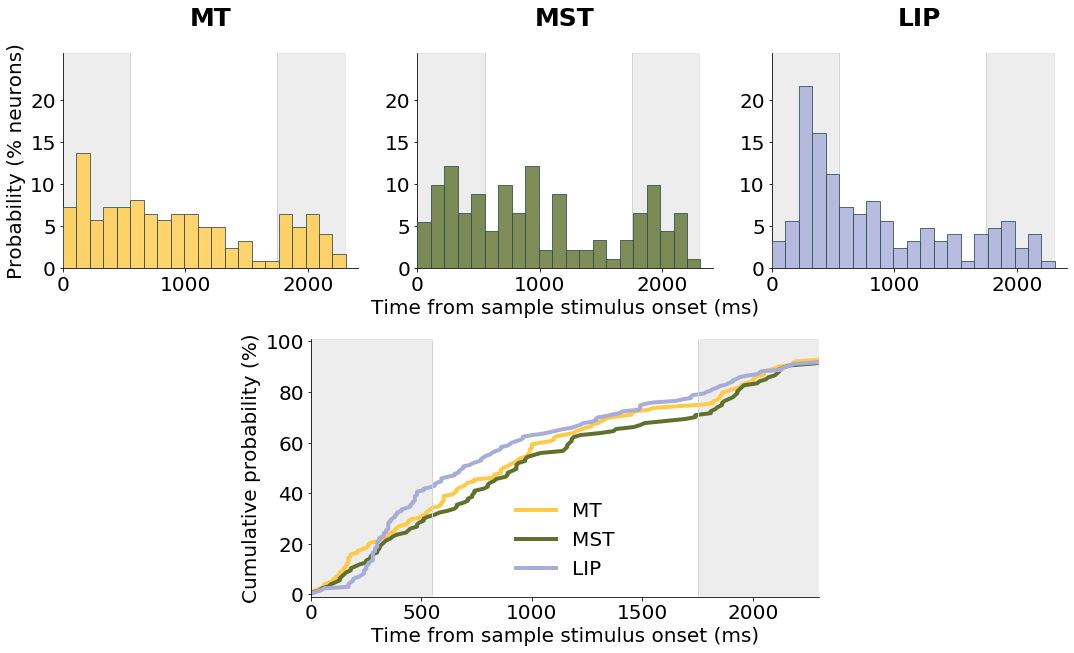

In [12]:
 ### Plot correlations
fig = plt.figure()
ax = fig.subplots(2, 6)
plt.close()
fig = plt.figure(constrained_layout=False, figsize=(18, 10))
widths = [4, 1, 4, 1, 1, 4]
heights = [1, 1.2]
gs = fig.add_gridspec(ncols = 6, nrows = 2, width_ratios = widths, height_ratios = heights, wspace = 0.5, hspace = 0.3)

ax[0, 0] = fig.add_subplot(gs[0, 0:2])
ax[0, 1]  = fig.add_subplot(gs[0, 2:4])
ax[0, 2]  = fig.add_subplot(gs[0, 4:])
ax[1, 0]  = fig.add_subplot(gs[1:, 1:5])

for i, area in enumerate(brain_areas[0:3]):
    [hists, edges] = np.histogram(latencies_all[area], bins = np.arange(0, TEST1+110, 110))
    ax[0, i].bar(edges[:-1], hists/(prop_tuned[area]*n_neurons[area])*100, 110, edgecolor = 'darkslategrey', alpha = 0.8, facecolor = plot_colors[area], label = area, align = 'edge', zorder = 20)  
    #ax[i].hist(latencies_all[area], bins = np.arange(0, 3000, 175), edgecolor = 'darkslategrey', alpha = 0.8, density = True, facecolor = plot_colors[area], label = area)
    ax[0, i].set_title(brain_areas[i], fontsize = 25, y = 1.1, fontweight = 'bold')
    
    for ii in range(2):
        ax[0, i].plot([TRIAL_EPOCHS[ii], TRIAL_EPOCHS[ii]], [0, 100], 'lightgrey', lw = 1)
        
    ax[0, i].axvspan(0, TRIAL_EPOCHS[0], alpha = 0.4, color = 'lightgrey', zorder=1)
    ax[0, i].axvspan(TRIAL_EPOCHS[1], TRIAL_EPOCHS[2], alpha = 0.4, color = 'lightgrey', zorder=2)


    ax[0, i].set_xlim(0, TEST1+110)
    ax[0, i].tick_params(labelsize=20)
    ax[0, i].set_ylim(0, 25.5)
    
    ax[0, i].set_yticks(np.arange(0, 21, 5))
    #ax[0, i].set(yticklabels = ytick_dirs)
    

ax[0, 0].set_ylabel('Probability (% neurons)', fontsize = 20)
ax[0, 1].set_xlabel('Time from sample stimulus onset (ms)', fontsize = 20)

# Hide the right and top spines
for i in range(3):
    ax[0, i].spines['right'].set_visible(False)
    ax[0, i].spines['top'].set_visible(False)

for i, area in enumerate(brain_areas):
    ax[1, 0].plot(x_vals[i], y_vals[i]*100, color = plot_colors[area], lw = 4, label = area)
    
ax[1, 0].plot([0, 0], [0, 100], 'lightgrey', lw = 1)
for i in range(4):
    ax[1, 0].plot([TRIAL_EPOCHS[i], TRIAL_EPOCHS[i]], [0, 100], 'lightgrey', lw = 1)
    
ax[1, 0].axvspan(0, TRIAL_EPOCHS[0], alpha = 0.4, color = 'lightgrey', zorder=1)
ax[1, 0].axvspan(TRIAL_EPOCHS[1], TRIAL_EPOCHS[2], alpha = 0.4, color = 'lightgrey', zorder=2)

ax[1, 0].set_ylabel('Cumulative probability (%)', fontsize = 20)
ax[1, 0].set_xlabel('Time from sample stimulus onset (ms)', fontsize = 20)
plt.ylim(-1, 101)
plt.xlim(0, TEST1)


plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=0)

# Hide the right and top spines
ax[1, 0].spines['right'].set_visible(False)
ax[1, 0].spines['top'].set_visible(False)

plt.tick_params(labelsize=20)

ax[1, 0].legend(frameon = False, fontsize = 20)

plt.show()
for i in save_filetype:
    savepath = figpath + 'rCTI\\' + monkey + '_rCTI_latency.' + i
    #fig.savefig(savepath, bbox_inches='tight')

### rCTI category-tuned only

In [419]:
rCTI_sliding_window_all = {}
rCTI_mean = {}
rCTI_std = {}

for area in brain_areas: 
    dirs = np.array(dirs)

    currpath = datapathsave + monkey + '\\' + area + '\\good_neurons\\task_responsive\\category_tuned\\'

    os.chdir(currpath)
    filelist = [f for f in glob.glob("*.mat")]
    n_files = len(filelist)

    rCTI_all = [[] for i in range(n_files)]

    for i, file in enumerate(filelist):
        data = sio.loadmat(file)['binned_spikes'][0]
        bins = sio.loadmat(file)['bins_raw'][0][0:-1]      
        
        psth_by_dir = [[] for i in range(12)]
        for ii, val in enumerate(np.arange(0, 72, 6)):
            psth_by_dir[ii] = np.vstack([iii for iii in data[val:val+6] if len(iii)> 0])

        [WCD_roc_all, WCD_roc] = get_WC_BC_ROC(psth_by_dir, WCD_pairs_indx, step_size)
        [BCD_roc_all, BCD_roc] = get_WC_BC_ROC(psth_by_dir, BCD_pairs_indx, step_size)
    
        rCTI_all[i] = BCD_roc-WCD_roc
    
    rCTI_sliding_window_all[area] = np.squeeze(rCTI_all)
    rCTI_mean[area] = np.mean(rCTI_all, 0)
    rCTI_std[area] = sp.stats.sem(rCTI_all, 0)
    
savepath = figpath + 'rCTI\\' + monkey + '_rCTI_category_tuned.mat'
sp.io.savemat(savepath,  {'rCTI_all': rCTI_sliding_window_all, 'rCTI_mean': rCTI_mean, 'rCTI_std': rCTI_std})

NameError: name 'dirs' is not defined

In [20]:
currdatapath = figpath + 'rCTI\\' + monkey + '_rCTI_category_tuned.mat'
rCTI_all_cat = sio.loadmat(currdatapath)['rCTI_all']
rCTI_mean_cat = sio.loadmat(currdatapath)['rCTI_mean']
rCTI_std_cat = sio.loadmat(currdatapath)['rCTI_std']

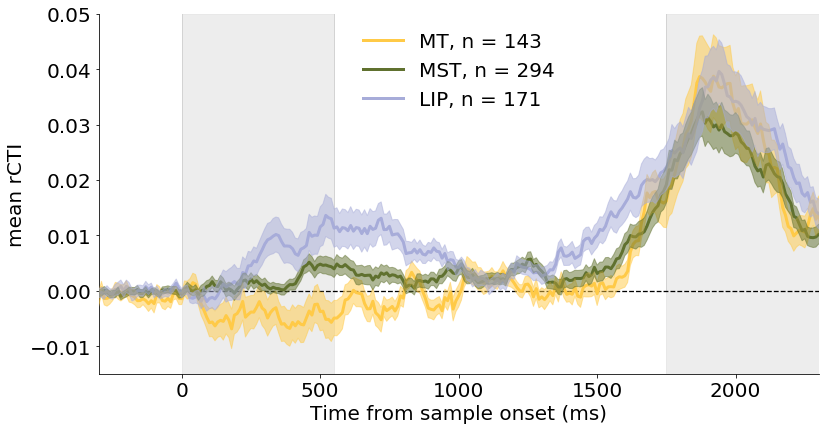

In [21]:
n_timepoints_total = len(data[0][0])
bins_plotting = np.arange(-500, 3050, 10)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([1,1,1,1])

ax.plot([0, 0], [0, 100], 'lightgrey', lw = 1)

for i in range(4):
    ax.plot([trial_epochs[i], trial_epochs[i]], [0, 100], 'lightgrey', lw = 1)

ax.plot([-500, 3000], [0, 0], '--k', lw = 1.3)
plt.ylim([-0.015, 0.05])
plt.xlim([-300, test1])

ax.axvspan(0, sample, alpha = 0.4, color = 'lightgrey', zorder=1)
ax.axvspan(delay1, test1, alpha = 0.4, color = 'lightgrey', zorder=2)

for area in brain_areas:
    
    currmean = np.squeeze(rCTI_mean_cat[area][0][0])
    currstd = np.squeeze(rCTI_std_cat[area][0][0])
    
    ax.plot(bins_plotting, currmean, color = plot_colors[area],  lw = 3, label = "{0}, n = {1}".format(area, n_neurons[area]))
    ax.fill_between(bins_plotting, currmean-currstd, currmean+currstd, color = plot_colors[area],  lw = 1., alpha = 0.5, zorder=20)
    
    
ax.set_xlabel('Time from sample onset (ms)', fontsize = 20)
ax.set_ylabel('mean rCTI', fontsize = 20)
ax.legend(frameon = False, fontsize = 20)

plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tick_params(labelsize=20)

for i in save_filetype:
    savepath = figpath + 'rCTI\\' + monkey + '_rCTI_sliding_window_cat_tuned.' + i
    fig.savefig(savepath, bbox_inches='tight')


## rCTI per epoch

In [ ]:
area = 'LIP'

dirs = np.array(dirs)

currpath = datapath + area + '\\good_neurons\\task_responsive\\'
currfigpath = figpath + 'psth\\' + area + '\\good_neurons\\'

os.chdir(currpath)
filelist = [f for f in glob.glob("*.mat")]
n_files = len(filelist)

#rCTI_all = [[] for i in range(n_files)]

for file in filelist:
    data = sio.loadmat(file)
    data = data['raw_spikes']
    data = np.array(np.squeeze(all_spikes))

    [WCD_roc_all, WCD_roc] = get_WC_BC_ROC(data, WCD_pairs_indx)
    [BCD_roc_all, BCD_roc] = get_WC_BC_ROC(data, BCD_pairs_indx)

    rCTI_all[i] = BCD_roc-WCD_roc
    
rCTI_mean = np.mean(rCTI_all, 0)
rCTI_sem = sp.stats.sem(rCTI_all, 0)

savepath = figpath + 'rCTI\\' + area + '_rCTI.mat'
sp.io.savemat(savepath,  {'rCTI_all': rCTI_all, 'rCTI_mean': rCTI_mean, 'rCTI_sem': rCTI_sem}) 


In [ ]:
def get_WC_BC_ROC_epoch(data, pairs_indx, trial_epochs):
    
    indx_baseline = epoch_inds(bins, -500, 0)
    indx_samp = epoch_inds(bins, 0, trial_epochs[0])
    indx_delay1 = epoch_inds(bins, trial_epochs[0], trial_epochs[1]-600)
    indx_delay2 = epoch_inds(bins, trial_epochs[1]-600, trial_epochs[1])
    indx_test1 = epoch_inds(bins, trial_epochs[1], trial_epochs[2])

    n_pairs = len(pairs_indx)
           
    [mean_baseline, all_baseline] = get_epoch_means(data, indx_baseline)
    [mean_samp, all_samp] = get_epoch_means(data, indx_samp)
    [mean_delay1, all_delay1] = get_epoch_means(data, indx_delay1)
    [mean_delay2, all_delay2] = get_epoch_means(data, indx_delay2)
    [mean_test1, all_test1] = get_epoch_means(data, indx_test1)    


    roc_all = np.zeros([n_pairs, n_timepoints])

    for i_pair in range(n_pairs):
        dir1 = data[pairs_indx[i_pair][0]]
        dir2 = data[pairs_indx[i_pair][1]]

        for i_timepoint in range(n_timepoints):
            y_true = np.hstack([np.zeros(np.size(dir1, 0)), np.ones(np.size(dir2, 0))])
            y_data = np.hstack([dir1[:, i_timepoint], dir2[:, i_timepoint]])    

            curr_roc = abs(roc_auc_score(y_true, y_data) - 0.5)
            roc_all[i_pair, i_timepoint] = curr_roc
            
    mean_roc = np.mean(roc_all, 0)

    return roc_all, mean_roc
        

# Decoder analysis

### Run direction and category decoders

In [92]:
n_neurons

{'MT': 183, 'MST': 172, 'LIP': 198, 'SC': 98}

In [94]:
n_iter = 200

In [95]:
count_matched = True

In [96]:
if run_decoders:
    cat_decoder_mean_all = {}
    dir_decoder_mean_all = {}

    for i_area, area in enumerate(brain_areas[2:4]):                   
        currpath = datapathsave + monkey + '\\' + area + '\\good_neurons\\task_responsive\\'
        os.chdir(currpath)
        filelist = [f for f in glob.glob("*.mat")]

        if count_matched:
            n_neurons_decoder = min([n_neurons[area] for area in brain_areas])     
            savepath_cat = figpath + 'category_decoding\\' +  monkey + '_cat_decoder_count_matched.mat'
            savepath_dir = figpath + 'direction_decoding\\' +  monkey + '_dir_decoder_count_matched.mat'
        else:
            n_neurons_decoder = n_neurons[area]    
            savepath_cat = figpath + 'category_decoding\\' +  monkey + '_cat_decoder_count_unmatched.mat'   
            savepath_dir = figpath + 'direction_decoding\\' +  monkey + '_dir_decoder_count_unmatched.mat'

        decoder_all, decoder_mean, decoder_std = run_decoder_dmc(area, filelist, bins, n_iter, 'cat', n_trials_cat, n_neurons_decoder, n_neurons[area]) 
        cat_decoder_mean_all[area] = {'decoder_mean': decoder_mean, 'decoder_std': decoder_std, 'decoder_all': decoder_all}

        #decoder_all, decoder_mean, decoder_std = run_decoder_dmc(area, filelist, bins, n_iter, 'dir', n_trials_dir, n_neurons_decoder, n_neurons[area]) 
        #dir_decoder_mean_all[area] = {'decoder_mean': decoder_mean, 'decoder_std': decoder_std, 'decoder_all': decoder_all}

    #sp.io.savemat(savepath_cat, {'cat_decoder_all': cat_decoder_mean_all}) 
    #sp.io.savemat(savepath_dir, {'dir_decoder_all': dir_decoder_mean_all})    

In [99]:
cat_decoder_mean_all

{'LIP': {'decoder_mean': array([47.86666667, 47.67083333, 48.7125    , 48.87083333, 48.45833333,
         48.07083333, 49.0875    , 50.33333333, 49.06666667, 50.175     ,
         49.675     , 49.94166667, 49.95833333, 50.56666667, 50.07916667,
         49.47083333, 49.2375    , 48.4375    , 48.425     , 49.41666667,
         48.83333333, 50.125     , 50.27083333, 49.175     , 50.07916667,
         49.2375    , 47.8       , 46.17083333, 46.3875    , 46.65416667,
         47.2125    , 47.15      , 47.74166667, 49.17083333, 50.65      ,
         49.54166667, 50.14166667, 49.94583333, 50.47083333, 52.81666667,
         50.22916667, 50.1375    , 50.44166667, 51.41666667, 54.34166667,
         55.63333333, 54.71666667, 54.7375    , 55.04166667, 55.425     ,
         55.525     , 54.30833333, 53.6375    , 52.7625    , 50.05416667,
         49.7125    , 49.1875    , 45.44583333, 45.70416667, 45.1125    ,
         43.10833333, 41.85833333, 39.89166667, 38.1375    , 38.05833333,
         38.145

In [97]:
plt.plot(bins_decoder, dir_decoder_mean_all['LIP']['decoder_mean'])
plt.plot(bins_decoder, dir_decoder_mean_all['SC']['decoder_mean']-2)

KeyError: 'LIP'

In [87]:
sp.io.savemat('E:\\two_boundary\\figures\\eye_movements\\'+'neural_cat_decoder_NEVILLE.mat', {'cat_decoder_all': cat_decoder_mean_all})

In [102]:
neural_decoder = sio.loadmat('E:\\two_boundary\\figures\\eye_movements\\'+'neural_cat_decoder.mat')['cat_decoder_all']['SC'][0][0][0]['decoder_mean'][0][0]

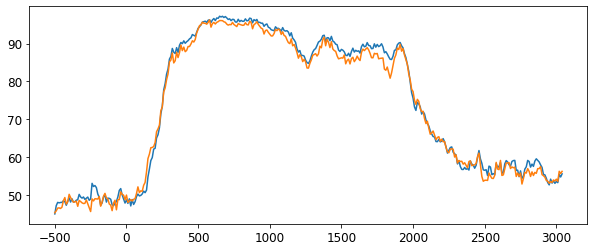

In [105]:
#plt.plot(bins_decoder, cat_decoder_mean_all['LIP']['decoder_mean'])
plt.plot(bins_decoder, cat_decoder_mean_all['SC']['decoder_mean'])
plt.plot(bins_decoder, neural_decoder)

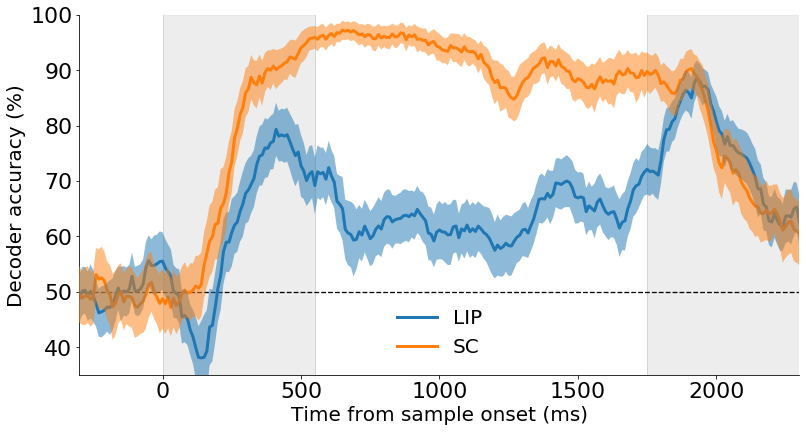

In [101]:

fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([1,1,1,1])

ax.plot([0, 0], [0, 100], 'lightgrey', lw = 1)
for i in range(4):
    ax.plot([TRIAL_EPOCHS[i], TRIAL_EPOCHS[i]], [0, 100], 'lightgrey', lw = 1)

ax.plot([-400, 3000], [50, 50], '--k', lw = 1.3)
plt.ylim([35, 100])
plt.xlim([-300, TEST1])
#plt.xlim([2800, test2])

ax.axvspan(0, SAMPLE_STIM, alpha = 0.4, color = 'lightgrey', zorder=1)
ax.axvspan(DELAY1, TEST1, alpha = 0.4, color = 'lightgrey', zorder=2)

for area in brain_areas[2:]:

    currmean = cat_decoder_mean_all[area]['decoder_mean']
    currstd = cat_decoder_mean_all[area]['decoder_std']

    ax.plot(bins_decoder, currmean,  lw = 3, label = area)
    ax.fill_between(bins_decoder, currmean-currstd, currmean+currstd,  lw = 1., alpha = 0.5, zorder=20)


ax.set_xlabel('Time from sample onset (ms)', fontsize = 20)
ax.set_ylabel('Decoder accuracy (%)', fontsize = 20)
ax.legend(frameon = False, fontsize = 20)

plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

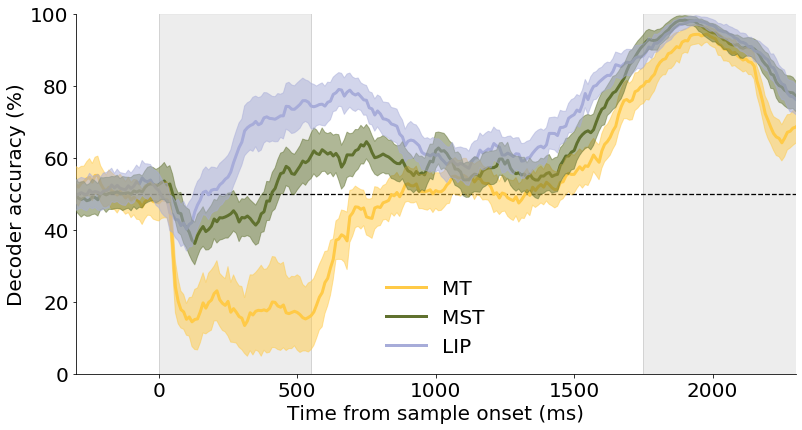

In [264]:
plot_decoder(cat_decoder_all, brain_areas, monkey, bins_decoder, save_fig = 'False')

In [11]:
def plot_decoder(decoder_all, brain_areas, monkey, bins, save_fig = False):

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_axes([1,1,1,1])

    ax.plot([0, 0], [0, 100], 'lightgrey', lw = 1)
    for i in range(4):
        ax.plot([TRIAL_EPOCHS[i], TRIAL_EPOCHS[i]], [0, 100], 'lightgrey', lw = 1)

    ax.plot([-400, 3000], [50, 50], '--k', lw = 1.3)
    plt.ylim([0, 100])
    plt.xlim([-300, TEST1])
    #plt.xlim([2800, test2])

    ax.axvspan(0, SAMPLE_STIM, alpha = 0.4, color = 'lightgrey', zorder=1)
    ax.axvspan(DELAY1, TEST1, alpha = 0.4, color = 'lightgrey', zorder=2)

    for area in brain_areas:

        currmean = decoder_all[area][0][0]['decoder_mean'][0][0]
        currstd = decoder_all[area][0][0]['decoder_std'][0][0]

        ax.plot(bins, currmean, color = plot_colors[area],  lw = 3, label = area)
        ax.fill_between(bins, currmean-currstd, currmean+currstd, color = plot_colors[area],  lw = 1., alpha = 0.5, zorder=20)


    ax.set_xlabel('Time from sample onset (ms)', fontsize = 20)
    ax.set_ylabel('Decoder accuracy (%)', fontsize = 20)
    ax.legend(frameon = False, fontsize = 20)

    plt.xticks(fontsize=22, rotation=0)
    plt.yticks(fontsize=22, rotation=0)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.tick_params(labelsize=20)
    
    if save_fig:
        for i in save_filetype:
            savepath = figpath + 'category_decoding\\' + monkey + '_cat_decoder_count_matched.' + i
            fig.savefig(savepath, bbox_inches='tight')


## Direction decoding

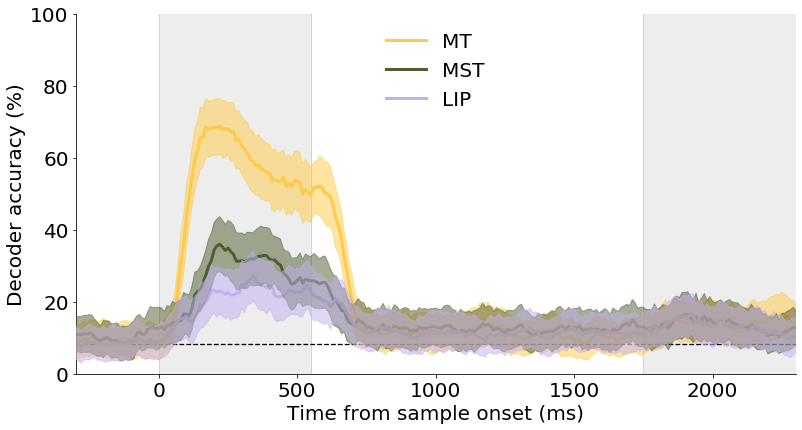

In [5]:
currdatapath = figpath + 'direction_decoding\\' +  monkey + '_dir_decoder_count_matched.mat'
dir_decoder_all = sio.loadmat(currdatapath)['dir_decoder_all'][0][0].flatten()

tp_plotting = np.arange(-500, 3050, 10)
       
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([1,1,1,1])
        
ax.plot([0, 0], [0, 100], 'lightgrey', lw = 1)
for i in range(4):
    ax.plot([TRIAL_EPOCHS[i], TRIAL_EPOCHS[i]], [0, 100], 'lightgrey', lw = 1)

ax.plot([-400, 3000], [1/12*100, 1/12*100], '--k', lw = 1.3)
plt.ylim([0, 100])
plt.xlim([-300, TEST1])
#plt.xlim([2800, test2])

ax.axvspan(0, SAMPLE_STIM, alpha = 0.4, color = 'lightgrey', zorder=1)
ax.axvspan(DELAY1, TEST1, alpha = 0.4, color = 'lightgrey', zorder=2)

for area in brain_areas:
    
    currmean = dir_decoder_all[area][0][0]['decoder_mean'][0][0]
    currstd = dir_decoder_all[area][0][0]['decoder_std'][0][0]
    #currmean = dir_decoder_mean_all[area]['decoder_mean']
    #currstd = dir_decoder_mean_all[area]['decoder_std']
    
    ax.plot(tp_plotting, currmean, color = plot_colors[area],  lw = 3, label = area)
    #ax.plot(tp_plotting, currmean, color = plot_colors[area],  lw = 3, label = "{0}, n = {1}".format(area, n_neurons[area]))
    ax.fill_between(tp_plotting, currmean-currstd, currmean+currstd, color = plot_colors[area],  lw = 1., alpha = 0.5, zorder=20)
    
    
ax.set_xlabel('Time from sample onset (ms)', fontsize = 20)
ax.set_ylabel('Decoder accuracy (%)', fontsize = 20)
ax.legend(frameon = False, fontsize = 20)

plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tick_params(labelsize=20)

for i in save_filetype:
    savepath = figpath + 'direction_decoding\\' + monkey + '_dir_decoder_count_unmatched.' + i
    #fig.savefig(savepath, bbox_inches='tight')
    

In [160]:
currdatapath = figpath + 'direction_decoding\\' +  monkey + '_dir_decoder_count_matched.mat'
perf_mean_dir = sio.loadmat(currdatapath)['perf_mean']
perf_std_dir = sio.loadmat(currdatapath)['perf_std']

KeyError: 'perf_mean'

### Plotting

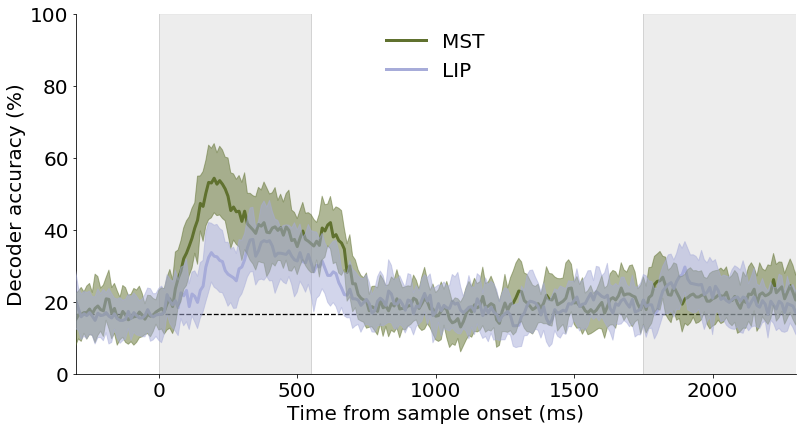

In [73]:
tp_plotting = np.arange(-500, 3050, 10)
       
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([1,1,1,1])
        
ax.plot([0, 0], [0, 100], 'lightgrey', lw = 1)
for i in range(4):
    ax.plot([trial_epochs[i], trial_epochs[i]], [0, 100], 'lightgrey', lw = 1)

ax.plot([-400, 3000], [1/6*100, 1/6*100], '--k', lw = 1.3)
plt.ylim([0, 100])
plt.xlim([-300, test1])
#plt.xlim([2800, test2])

ax.axvspan(0, sample, alpha = 0.4, color = 'lightgrey', zorder=1)
ax.axvspan(delay1, test1, alpha = 0.4, color = 'lightgrey', zorder=2)

for area in brain_areas:
    
    currmean = np.squeeze(perf_mean_dir[area][0][0])
    currstd = np.squeeze(perf_std_dir[area][0][0])
    
    ax.plot(tp_plotting, currmean, color = plot_colors[area],  lw = 3, label = area)
    #ax.plot(tp_plotting, currmean, color = plot_colors[area],  lw = 3, label = "{0}, n = {1}".format(area, n_neurons[area]))
    ax.fill_between(tp_plotting, currmean-currstd, currmean+currstd, color = plot_colors[area],  lw = 1., alpha = 0.5, zorder=20)
    
    
ax.set_xlabel('Time from sample onset (ms)', fontsize = 20)
ax.set_ylabel('Decoder accuracy (%)', fontsize = 20)
ax.legend(frameon = False, fontsize = 20)

plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tick_params(labelsize=20)

for i in save_filetype:
    savepath = figpath + 'direction_decoding\\' + monkey + '_dir_decoder_unmatched_count.' + i
    fig.savefig(savepath, bbox_inches='tight')


In [65]:
tp_plotting = np.arange(-500, 3050, 10)
       
fig, ax =  plt.subplots(1, 3, figsize=(20, 4.5))

for i in range(3):
    ax[i].plot([0, 0], [0, 100], 'lightgrey', lw = 1)
    for ii in range(4):
        ax[i].plot([trial_epochs[ii], trial_epochs[ii]], [0, 100], 'lightgrey', lw = 1)
    ax[i].plot([-400, 3000], [1/6*100, 1/6*100], '--k', lw = 1.3)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].axvspan(0, sample, alpha = 0.4, color = 'lightgrey', zorder=1)
    ax[i].axvspan(delay1, test1, alpha = 0.4, color = 'lightgrey', zorder=2)
    ax[i].set_ylim(10, 60)
    ax[i].set_xlim(-300, test1)
    ax[i].set_title(brain_areas[i], fontsize = 20)
    
ax[0].plot(tp_plotting, perf_cat_MT, color = color_MT, linestyle = '--', lw = 2.5)
ax[0].plot(tp_plotting, perf_cat_MT_all, color = color_MT, lw = 2.5)
ax[0].set_ylabel('Performance (%)', fontsize = 20)

ax[1].plot(tp_plotting, perf_cat_MST, color = color_MST, linestyle = '--', lw = 2.5)
ax[1].plot(tp_plotting, perf_cat_MST_all, color = color_MST, lw = 2.5, zorder = 10)
ax[1].plot(tp_plotting, perf_cat_MST, color = 'k', linestyle = '--', lw = 2.5, label = 'Only category-tuned neurons', zorder=1)
ax[1].plot(tp_plotting, perf_cat_MST_all, color = 'k', lw = 2.5, label = 'All neurons', zorder=1)
ax[1].set_xlabel('Time from sample onset (ms)', fontsize = 20)
ax[1].legend(frameon = False, fontsize = 15)

ax[2].plot(tp_plotting, perf_cat_LIP, color = color_LIP, linestyle = '--', lw = 2.5)
ax[2].plot(tp_plotting, perf_cat_LIP_all, color = color_LIP, lw = 2.5)

#savepath = figpath + 'direction_decoding\\dir_decoder_cat_tuned_comparison.png'
#fig.savefig(savepath, bbox_inches='tight')


# Variance alignment

In [5]:

monkey = 'Stanton'
n_dims = 12

In [8]:
from sklearn.decomposition import PCA

indx1 = 150
indx2 = 250

sample_timepoints = np.arange(np.where(bins == indx1)[0][0], np.where(bins == indx2)[0][0])
test_timepoints = np.arange(np.where(bins == DELAY1+indx1)[0][0], np.where(bins == DELAY1+indx2)[0][0])

all_variances = {}

for area in brain_areas:
    
    all_variances[area] = {}
    
    if monkey != 'both':
        currpath = datapathsave + monkey + '\\' + area + '\\good_neurons\\task_responsive\\'
        os.chdir(currpath)
        filelist = [f for f in glob.glob("*.mat")]

    else:
        currpath1 = datapathsave + 'Neville' + '\\' + area + '\\good_neurons\\task_responsive\\'   
        currpath2 = datapathsave + 'Stanton' + '\\' + area + '\\good_neurons\\task_responsive\\'
      
        os.chdir(currpath1)
        filelist1 = [os.path.abspath(f) for f in glob.glob("*.mat")]  
        os.chdir(currpath2)
        filelist2 = [os.path.abspath(f) for f in glob.glob("*.mat")]  
        
        filelist = np.hstack([filelist1, filelist2])
        
    spikes_all = []

    for file in filelist:
        data = sio.loadmat(file)
        data_by_cond = data['binned_spikes'].flatten()*10
        data_by_dir = org_data_by_dir(data_by_cond)
        stacked_sample = np.hstack([gaussian_filter1d(np.mean(data_by_dir[i][:, sample_timepoints], 0), 30) for i in CENTER_DIRS])       
        
        data_by_test = org_data_by_test(data_by_cond)
        stacked_test = np.hstack([gaussian_filter1d(np.mean(i[:, test_timepoints], 0), 30) for i in data_by_test[0]])   
        
        #stacked_sample = np.hstack([gaussian_filter1d(np.mean(data_by_test[1][i][:, test_timepoints], 0), 30) for i in range(0, 8, 2)])  
        #stacked_test = np.hstack([gaussian_filter1d(np.mean(data_by_test[1][i][:, test_timepoints], 0), 30) for i in range(1, 8, 2)])   
        
        stacked = np.hstack([stacked_sample, stacked_test])
        spikes_all.append(stacked.T)
        
    all_stacked = np.array(spikes_all).T    

    pca = PCA(n_components = len(filelist))
    pca.fit(all_stacked)

    projection = pca.transform(all_stacked)

    #n_timepoints = len(timepoints)

    #pca_indices = {}

    #for i_dir in range(N_DIRS):
        #startindx = 0+(n_timepoints*i_dir)
        #pca_indices[i_dir] = [startindx, startindx+n_timepoints]        
        
    new_data = projection[:, 0:n_dims]
    samp = new_data[0:len(sample_timepoints)*4]
    test = new_data[len(sample_timepoints)*4:]
    
    #samp = []
    #test = []

    #for i in range(0, 12):
        #samp.append(new_data[len(timepoints)*i+200:300+len(timepoints)*i])
        #test.append(new_data[len(timepoints)*i+1950:len(timepoints)*i+1950+100])
        #samp.append(new_data[len(timepoints)*i+300:len(timepoints)*i+400])
        #test.append(new_data[len(timepoints)*i+400:500+len(timepoints)*i])
        
    #samp = np.vstack(samp)
    #test = np.vstack(test)
    
    sp.io.savemat('E:\\two_boundary\\' + area + '.mat', {'samp': samp, 'test': test})    

    pca = PCA(n_components = n_dims)
    pca.fit(samp)
    projection = pca.transform(test)
    
    vars_proj = [np.var(projection[:, i]) for i in range(n_dims)]
    all_variances[area]['samp_test'] = vars_proj

    pca.fit(test)
    all_variances[area]['test_test'] = pca.explained_variance_
    
    n_rand = 10000

    random_vals = np.zeros([n_rand, n_dims])
    C = np.cov(test.T)

    for i_rand in range(n_rand):
        coeffRand = sp.linalg.orth(np.random.rand(n_dims, n_dims))
        random_vals[i_rand] = np.diag(coeffRand.T @ C @ coeffRand)
        
    all_variances[area]['random'] = random_vals
    
    

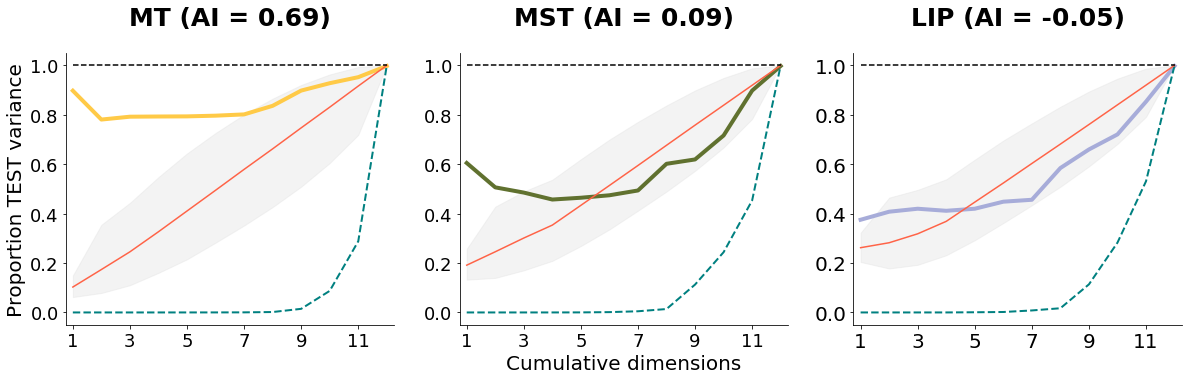

In [10]:
fig, ax =  plt.subplots(1, 3, figsize=(20, 5))
    
for i, area in enumerate(brain_areas):
    
    data_line =  np.cumsum(all_variances[area]['samp_test'])/np.cumsum(all_variances[area]['test_test'])
    rand_line = np.cumsum(np.mean(all_variances[area]['random'], 0))/np.cumsum(all_variances[area]['test_test'])
    randCum = np.vstack([np.cumsum(row) for row in all_variances[area]['random']])
    randCI = np.quantile(randCum, [0.025, 0.975], 0)/np.cumsum(all_variances[area]['test_test'])
    misalign = np.cumsum(list(reversed(all_variances[area]['test_test'])))/np.cumsum(all_variances[area]['test_test'])
    
    raw_val = sum(data_line-rand_line)
    if raw_val > 0:
        align_indx = raw_val/sum(1-rand_line)
    else:
        align_indx = raw_val/sum(rand_line - misalign)

    
    #tmp = all_variances[area]['samp_test']/all_variances[area]['test_test']
    ax[i].plot(range(1, n_dims+1),data_line, color = plot_colors[area], lw = 4)
    ax[i].plot(range(1, n_dims+1), misalign, '--', color = 'teal', label = 'Maximally misaligned', lw = 2)
    ax[i].plot(range(1, n_dims+1), rand_line, color = 'tomato', label = 'Random')
    ax[i].plot(range(1, n_dims+1), np.ones(n_dims), '--', color = 'k', label = 'Perfect alignment')
    ax[i].fill_between(range(1, n_dims+1), randCI[0], randCI[1], color = 'lightgrey', lw = 1., alpha = 0.25)
    #ax[i].plot(range(1, n_dims+1), np.cumsum(all_variances[area]['samp_test']), color = plot_colors[area], label = area, lw = 2)

    ax[i].set_xlim(0.75, n_dims + 0.25)
    ax[i].set_xticks(np.arange(1, n_dims+1, 2))
    #ax[i].legend(frameon = False, fontsize = 20)
    #plt.ylim(0, 1.1)
    ax[i].set_title(area + ' (AI = {:.2f})'.format(align_indx), fontsize = 25, y = 1.08, fontweight='bold')

    ax[i].tick_params(labelsize = 18)

    # Hide the right and top spines
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

    plt.tick_params(labelsize=20)
    
ax[1].set_xlabel('Cumulative dimensions', fontsize = 20)
ax[0].set_ylabel('Proportion TEST variance', fontsize = 20)

for i in save_filetype:
    savepath = figpath + 'pca\\' + monkey + '_variance_alignment_dmc_samp_test_150_250.' + i
    fig.savefig(savepath, bbox_inches='tight')
 

In [994]:
align_indx

array([-5.31887483e+00, -3.79754210e+00, -2.78596532e+00, -2.22710215e+00,
       -1.85291278e+00, -1.59716269e+00, -1.40946255e+00, -1.26722358e+00,
       -1.16986580e+00, -1.11001259e+00, -1.27589158e+00, -1.03056086e+15])

### All timepoints

In [708]:
monkey = 'both'
n_dims = 12

(8, 8)

In [ ]:
from sklearn.decomposition import PCA

timepoints = np.arange(np.where(bins == -100)[0][0], np.where(bins == TEST1)[0][0])

all_variances = {}

for area in brain_areas:
    
    all_variances[area] = {}
    
    if monkey != 'both':
        currpath = datapathsave + monkey + '\\' + area + '\\good_neurons\\task_responsive\\'
        os.chdir(currpath)
        filelist = [f for f in glob.glob("*.mat")]

    else:
        currpath1 = datapathsave + 'Neville' + '\\' + area + '\\good_neurons\\task_responsive\\'   
        currpath2 = datapathsave + 'Stanton' + '\\' + area + '\\good_neurons\\task_responsive\\'
      
        os.chdir(currpath1)
        filelist1 = [os.path.abspath(f) for f in glob.glob("*.mat")]  
        os.chdir(currpath2)
        filelist2 = [os.path.abspath(f) for f in glob.glob("*.mat")]  
        
        filelist = np.hstack([filelist1, filelist2])
        
    spikes_all = []

    for file in filelist:
        data = sio.loadmat(file)
        data_by_cond = data['binned_spikes'].flatten()*10
        data_by_dir = org_data_by_dir(data_by_cond)
        stacked = np.hstack([gaussian_filter1d(np.mean(i[:, timepoints], 0), 30) for i in data_by_dir])       
        spikes_all.append(stacked.T)
        
        
    all_stacked = np.array(spikes_all).T    

    pca = PCA(n_components = len(filelist))
    pca.fit(all_stacked)

    projection = pca.transform(all_stacked)

    n_timepoints = len(timepoints)

    pca_indices = {}

    for i_dir in range(N_DIRS):
        startindx = 0+(n_timepoints*i_dir)
        pca_indices[i_dir] = [startindx, startindx+n_timepoints]        
        
    new_data = projection[:, 0:n_dims]
    samp = []
    test = []

    for i in range(0, 12):
        samp.append(new_data[0*i+300:0*i+400])
        test.append(new_data[0*i+400:500+0*i])
        
    samp = np.vstack(samp)
    test = np.vstack(test)
    
    sp.io.savemat('E:\\two_boundary\\' + area + '.mat', {'samp': samp, 'test': test})    

    pca = PCA(n_components = n_dims)
    pca.fit(samp)
    projection = pca.transform(test)
    
    vars_proj = [np.var(projection[:, i]) for i in range(n_dims)]
    all_variances[area]['samp_test'] = vars_proj

    pca.fit(test)
    all_variances[area]['test_test'] = pca.explained_variance_
    
    n_rand = 10000

    random_vals = np.zeros([n_rand, n_dims])
    C = np.cov(test.T)

    for i_rand in range(n_rand):
        coeffRand = sp.linalg.orth(np.random.rand(n_dims, n_dims))
        random_vals[i_rand] = np.diag(coeffRand.T @ C @ coeffRand)
        
    all_variances[area]['random'] = random_vals
    
    

In [ ]:
fig, ax =  plt.subplots(1, 3, figsize=(20, 5))
    
for i, area in enumerate(brain_areas):
    
    data_line =  np.cumsum(all_variances[area]['samp_test'])/np.cumsum(all_variances[area]['test_test'])
    rand_line = np.cumsum(np.mean(all_variances[area]['random'], 0))/np.cumsum(all_variances[area]['test_test'])
    randCum = np.vstack([np.cumsum(row) for row in all_variances[area]['random']])
    randCI = np.quantile(randCum, [0.025, 0.975], 0)/np.cumsum(all_variances[area]['test_test'])
    misalign = np.cumsum(list(reversed(all_variances[area]['test_test'])))/np.cumsum(all_variances[area]['test_test'])
    
    raw_val = sum(data_line-rand_line)
    if raw_val > 0:
        align_indx = raw_val/sum(1-rand_line)
    else:
        align_indx = raw_val/(rand_line - misalign)

    
    #tmp = all_variances[area]['samp_test']/all_variances[area]['test_test']
    ax[i].plot(range(1, n_dims+1),data_line, color = plot_colors[area], lw = 4)
    ax[i].plot(range(1, n_dims+1), misalign, '--', color = 'teal', label = 'Maximally misaligned', lw = 2)
    ax[i].plot(range(1, n_dims+1), rand_line, color = 'tomato', label = 'Random')
    ax[i].plot(range(1, n_dims+1), np.ones(n_dims), '--', color = 'k', label = 'Perfect alignment')
    ax[i].fill_between(range(1, n_dims+1), randCI[0], randCI[1], color = 'lightgrey', lw = 1., alpha = 0.25)
    #ax[i].plot(range(1, n_dims+1), np.cumsum(all_variances[area]['samp_test']), color = plot_colors[area], label = area, lw = 2)

    ax[i].set_xlim(0.75, n_dims + 0.25)
    ax[i].set_xticks(np.arange(1, n_dims+1, 2))
    #ax[i].legend(frameon = False, fontsize = 20)
    #plt.ylim(0, 1.1)
    ax[i].set_title(area + ' (AI = {:.2f})'.format(align_indx), fontsize = 25, y = 1.08, fontweight='bold')

    ax[i].tick_params(labelsize = 18)

    # Hide the right and top spines
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

    plt.tick_params(labelsize=20)
    
ax[1].set_xlabel('Cumulative dimensions', fontsize = 20)
ax[0].set_ylabel('Proportion TEST variance', fontsize = 20)

for i in save_filetype:
    savepath = figpath + 'pca\\' + monkey + '_variance_alignment_dmc_control.' + i
    fig.savefig(savepath, bbox_inches='tight')
 

In [361]:
plt.plot(all_stacked[0:len(timepoints), 0], 'r')
plt.plot(all_stacked[len(timepoints)*1:len(timepoints)*2, 0], 'r')
plt.plot(all_stacked[len(timepoints)*2:len(timepoints)*3, 0], 'r')
plt.plot(all_stacked[len(timepoints)*3:len(timepoints)*4, 0], 'r')
plt.plot(all_stacked[len(timepoints)*4:len(timepoints)*5, 0], 'r')
plt.plot(all_stacked[len(timepoints)*5:len(timepoints)*6, 0], 'r')
plt.plot(all_stacked[len(timepoints)*6:len(timepoints)*7, 0], 'b')
plt.plot(all_stacked[len(timepoints)*7:len(timepoints)*8, 0], 'b')
plt.plot(all_stacked[len(timepoints)*8:len(timepoints)*9, 0], 'b')
plt.plot(all_stacked[len(timepoints)*9:len(timepoints)*10, 0], 'b')
plt.plot(all_stacked[len(timepoints)*10:len(timepoints)*11, 0], 'b')
plt.plot(all_stacked[len(timepoints)*11:len(timepoints)*12, 0], 'b')

ValueError: all the input array dimensions except for the concatenation axis must match exactly

ValueError: x and y must have same first dimension, but have shapes (198,) and (12,)

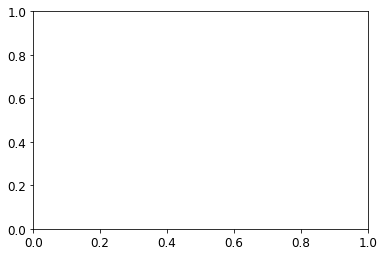

In [880]:
%matplotlib inline
plt.plot(range(0, len(filelist)), pca.explained_variance_ratio_)
plt.xlim(0, 10)

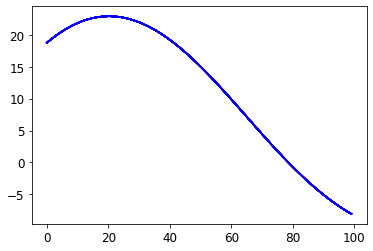

In [894]:
%matplotlib inline

for i_dir in range(6):
    plt.plot(projection[0:100, 0], 'r')
    plt.plot(projection[100:200, 0], 'r')
    plt.plot(projection[200:300, 0], 'r')
    plt.plot(projection[300:400, 0], 'r')
    
for i_dir in range(6, 12):
    plt.plot(projection[600:700, 0], 'b')
    plt.plot(projection[700:800, 0], 'b')
    plt.plot(projection[800:900, 0], 'b')

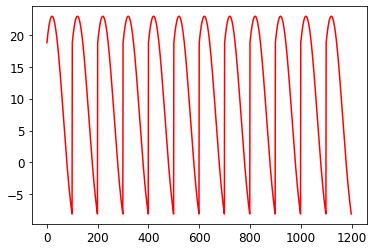

In [893]:
%matplotlib inline

for i_dir in range(6):
    plt.plot(projection[pca_indices[i_dir][0]:pca_indices[i_dir][1], 0], 'r')

    
for i_dir in range(6, 12):
    plt.plot(projection[pca_indices[i_dir][0]:pca_indices[i_dir][1], 0], 'b')

#plt.ylim(50, 70)

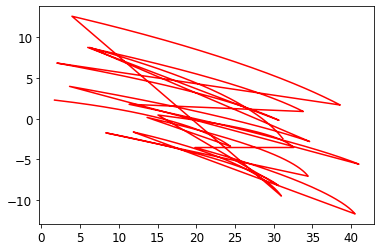

In [875]:
%matplotlib inline

for i_dir in range(6):
    plt.plot(projection[pca_indices[i_dir][0]:pca_indices[i_dir][1], 0], projection[pca_indices[i_dir][0]:pca_indices[i_dir][1], 1], 'r')
    
for i_dir in range(6, 12):
    plt.plot(projection[pca_indices[i_dir][0]:pca_indices[i_dir][1], 0], projection[pca_indices[i_dir][0]:pca_indices[i_dir][1], 1], 'b')



<IPython.core.display.Javascript object>


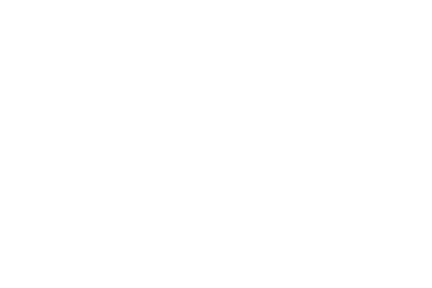

Text(0.5, 0, 'PC1')

<IPython.core.display.Javascript object>


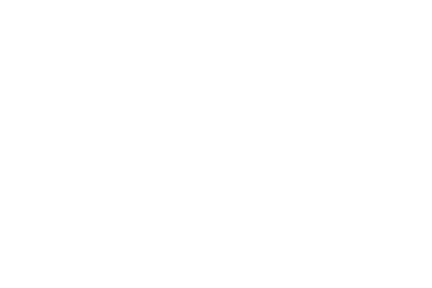

In [878]:
from mpl_toolkits import mplot3d
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')

for i_dir in range(3):
    inds = pca_indices[i_dir]
    ax.plot(projection[inds[0]:inds[1], 0], projection[inds[0]:inds[1], 1], projection[inds[0]:inds[1], 2], '--', color = plot_colors['Category1'])

for i_dir in range(3, 6):
    inds = pca_indices[i_dir]
    ax.plot(projection[inds[0]:inds[1], 0], projection[inds[0]:inds[1], 1], projection[inds[0]:inds[1], 2], plot_colors['Category1'])
        
for i_dir in range(6, 9):
    inds = pca_indices[i_dir]
    ax.plot(projection[inds[0]:inds[1], 0], projection[inds[0]:inds[1], 1], projection[inds[0]:inds[1], 2], '--', color = plot_colors['Category2'])

for i_dir in range(9, 12):
    inds = pca_indices[i_dir]
    ax.plot(projection[inds[0]:inds[1], 0], projection[inds[0]:inds[1], 1], projection[inds[0]:inds[1], 2], plot_colors['Category2'])

ax.set_xlabel('PC1')

<IPython.core.display.Javascript object>


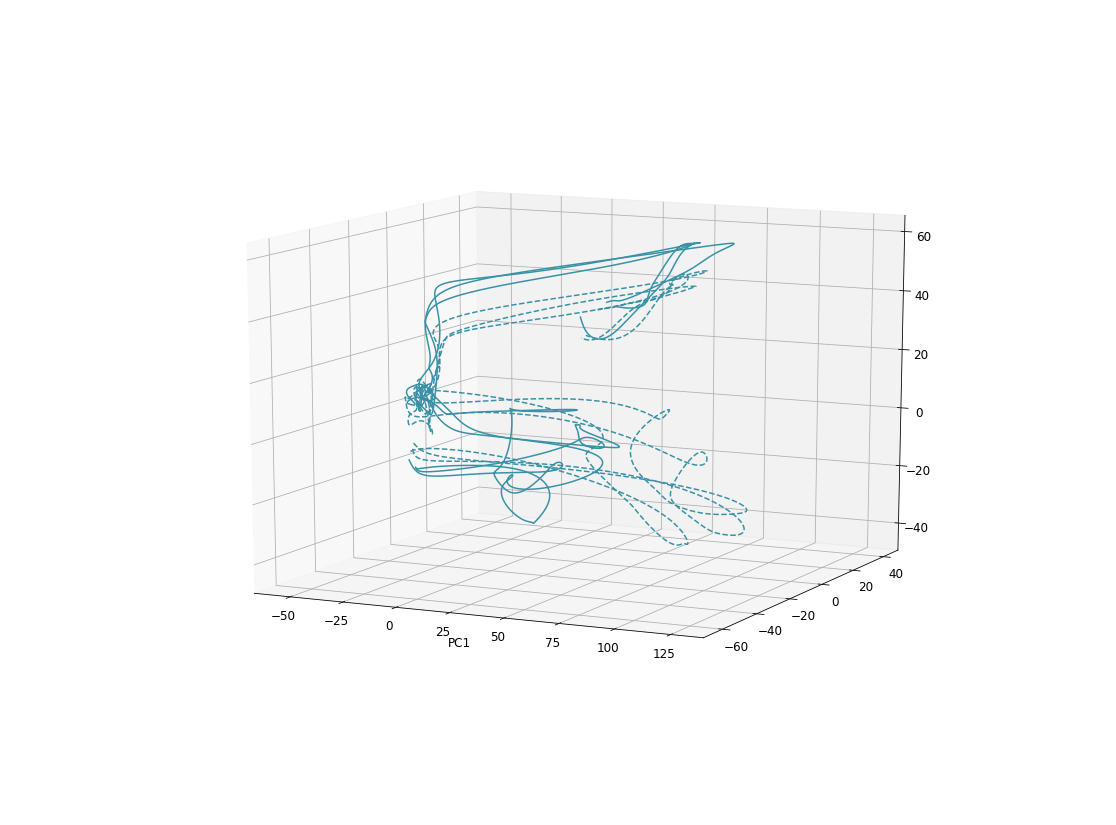

Text(0.5, 0, 'PC1')

In [385]:
from mpl_toolkits import mplot3d
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')

for i_dir in range(3):
    inds = pca_indices[i_dir]
    ax.plot(projection[inds[0]:inds[1], 0], projection[inds[0]:inds[1], 1], projection[inds[0]:inds[1], 2], '--', color = plot_colors['Category1'])

for i_dir in range(3, 6):
    inds = pca_indices[i_dir]
    ax.plot(projection[inds[0]:inds[1], 0], projection[inds[0]:inds[1], 1], projection[inds[0]:inds[1], 2], plot_colors['Category1'])
ax.set_xlabel('PC1')        

<IPython.core.display.Javascript object>


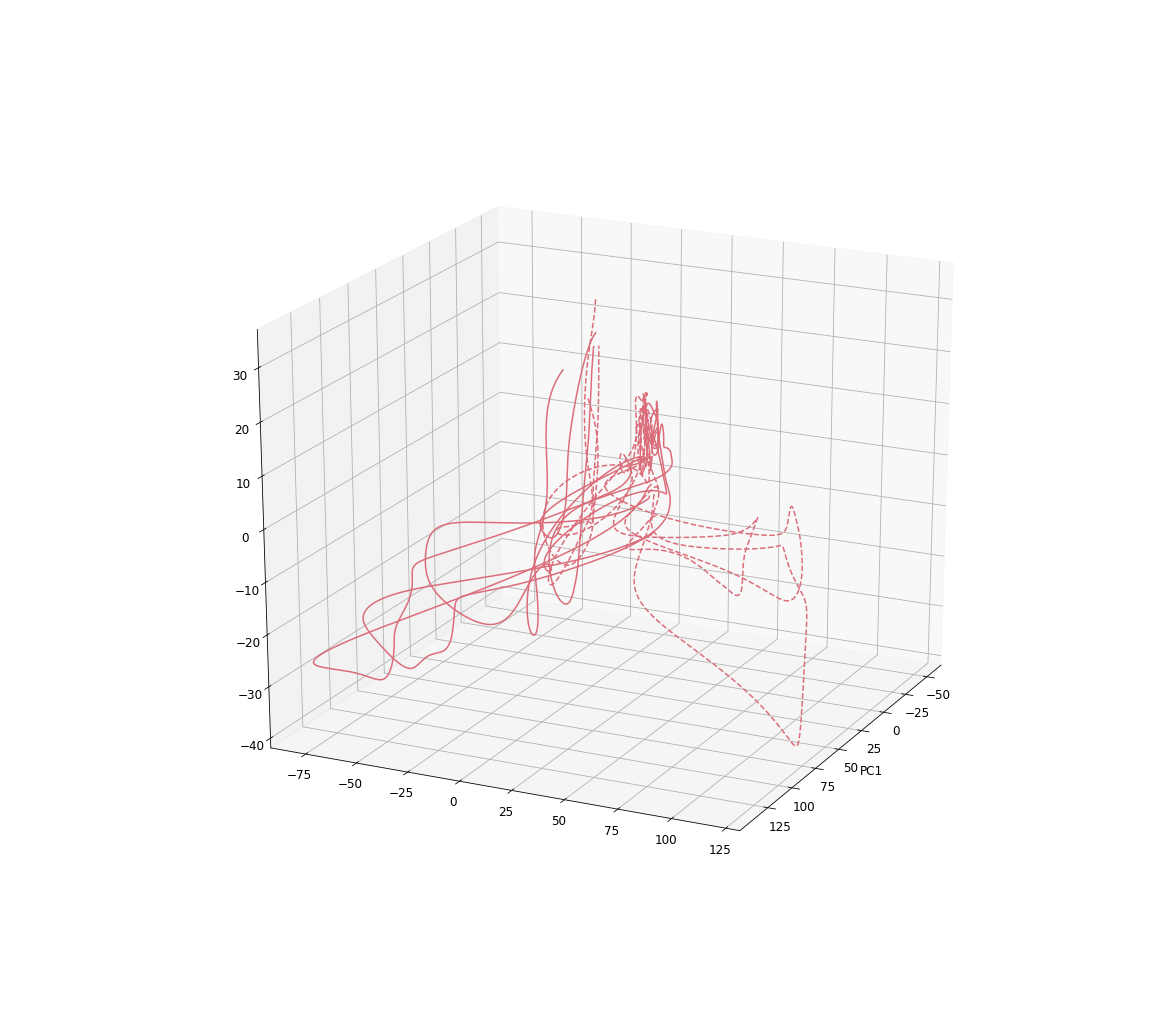

Text(0.5, 0, 'PC1')

In [387]:
from mpl_toolkits import mplot3d
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')


for i_dir in range(6, 9):
    inds = pca_indices[i_dir]
    ax.plot(projection[inds[0]:inds[1], 0], projection[inds[0]:inds[1], 1], projection[inds[0]:inds[1], 2], '--', color = plot_colors['Category2'])

for i_dir in range(9, 12):
    inds = pca_indices[i_dir]
    ax.plot(projection[inds[0]:inds[1], 0], projection[inds[0]:inds[1], 1], projection[inds[0]:inds[1], 2], plot_colors['Category2'])

ax.set_xlabel('PC1')        

In [254]:
tp = np.arange(np.where(bins == DELAY1-100)[0][0], np.where(bins == TEST1)[0][0])

cat1_45 = [2,8,15,20,26,31,40,42,46,48,52,54,58,60,64,66,70,72]
cat1_225 = [1,7,13,20,26,32,39,41,45,47,51,53,57,59,63,65,69,71]
cat2_135 = [3,5,9,11,15,17,22,24,28,30,34,36,37,43,49,56,62,68]
cat2_315 = [4,6,10,12,16,18,21,23,27,29,33,35,38,44,50,55,61,67]


In [319]:
rCTI_sliding_window_all = {}
rCTI_mean = {}
rCTI_std = {}

for area in brain_areas[0:1]: 
    currpath = datapathsave + monkey + '\\' + area + '\\good_neurons\\task_responsive\\'

    os.chdir(currpath)
    filelist = [f for f in glob.glob("*.mat")]
    n_files = len(filelist)

    rCTI_all = [[] for i in range(n_files)]

    for i, file in enumerate(filelist[67:69]):
        data = sio.loadmat(file)['raw_spikes'][0]*1000
        
        cat1_1_sample1 = np.vstack([data[i-1] for i in cat1_45 if len(data[i-1]) > 0 and i <= 36])
        cat1_2_sample1 = np.vstack([data[i-1] for i in cat1_225 if len(data[i-1]) > 0 and i <= 36])
        cat1_1_sample2 = np.vstack([data[i-1] for i in cat1_45 if len(data[i-1]) > 0 and i > 37])
        cat1_2_sample2 = np.vstack([data[i-1] for i in cat1_225 if len(data[i-1]) > 0 and i > 37])
        
        cat2_1_sample2 = np.vstack([data[i-1] for i in cat2_135 if len(data[i-1]) > 0 and i > 37])
        cat2_2_sample2 = np.vstack([data[i-1] for i in cat2_315 if len(data[i-1]) > 0 and i > 37])
        cat2_1_sample1 = np.vstack([data[i-1] for i in cat2_135 if len(data[i-1]) > 0 and i <= 36])
        cat2_2_sample1 = np.vstack([data[i-1] for i in cat2_315 if len(data[i-1]) > 0 and i <= 36])

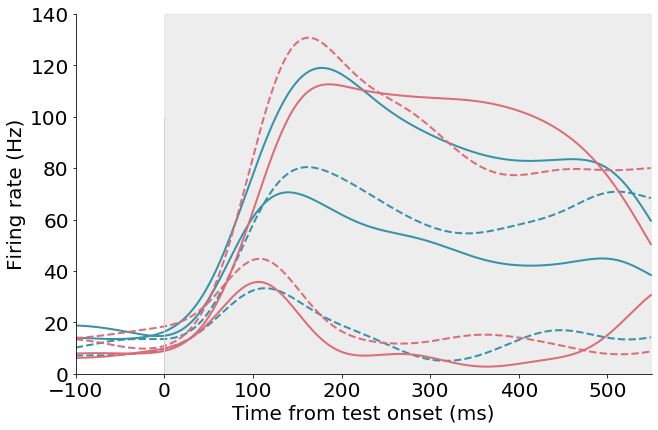

In [325]:
%matplotlib inline
fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes([1,1,1,1])
    
ax.plot(range(-100, len(tp)-100), gaussian_filter1d(np.mean(cat1_1_sample1, 0), sm_std)[tp], color = plot_colors['Category1'], lw = 2)
ax.plot(range(-100, len(tp)-100), gaussian_filter1d(np.mean(cat1_2_sample1, 0), sm_std)[tp], color = plot_colors['Category1'], lw = 2)
ax.plot(range(-100, len(tp)-100), gaussian_filter1d(np.mean(cat1_1_sample2, 0), sm_std)[tp], '--', color = plot_colors['Category1'], lw = 2)
ax.plot(range(-100, len(tp)-100), gaussian_filter1d(np.mean(cat1_2_sample2, 0), sm_std)[tp], '--', color = plot_colors['Category1'], lw = 2)

ax.plot(range(-100, len(tp)-100), gaussian_filter1d(np.mean(cat2_1_sample2, 0), sm_std)[tp], color = plot_colors['Category2'], lw = 2)
ax.plot(range(-100, len(tp)-100), gaussian_filter1d(np.mean(cat2_2_sample2, 0), sm_std)[tp], color = plot_colors['Category2'], lw = 2)
ax.plot(range(-100, len(tp)-100), gaussian_filter1d(np.mean(cat2_1_sample1, 0), sm_std)[tp], '--', color = plot_colors['Category2'], lw = 2)
ax.plot(range(-100, len(tp)-100), gaussian_filter1d(np.mean(cat2_2_sample1, 0), sm_std)[tp], '--', color = plot_colors['Category2'], lw = 2)

ax.plot([0, 0], [0, 100], 'lightgrey', lw = 1)

ax.set_xlabel('Time from test onset (ms)', fontsize = 20)
ax.set_ylabel('Firing rate (Hz)', fontsize = 20)

#ax.axvspan(0, TRIAL_EPOCHS[0], alpha = 0.4, color = 'lightgrey', zorder=1)
ax.axvspan(0, 550, alpha = 0.4, color = 'lightgrey', zorder=2)

plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=0)

plt.xlim((-100, 550))
plt.ylim((0, 140))

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tick_params(labelsize=20)


In [318]:
filelist[68]

'20200424_1_SPK12a.mat'